In [1]:
# Basic Tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import matplotlib.colors as mcolors
#import seaborn as sns
from scipy.stats import randint, uniform, norm, expon, lognorm, multivariate_normal
from scipy.spatial import distance_matrix
import scipy.integrate as integrate

from astropy.table import Table#, vstack, hstack, join
#import astropy.units as u
import h5py
import copy
#import corner
import os

# Notes

- Most stars in clusters have up to 25 element abundances measured, but in some cases there are clusters that have less, down to 21 measured element abundances. So in X[j] I would like, if useful, to have NaNs in the elements that dont have the respective measurement, and then for the statistics just ommit the NaN values.

- There are clusters with 1 star (may consider doing histogram of number of stars)

# Network

## Data

In [2]:
abusolar_cluster_giants = Table.read('data/abusolar_cluster_giants.csv')
abusolar_star_giants_individual_stars = Table.read('data/abusolar_star_giants_individual_stars.csv')

In [3]:
abusolar_cluster_giants = pd.read_csv('data/abusolar_cluster_giants.csv')
abusolar_star_giants_individual_stars = pd.read_csv('data/abusolar_star_giants_individual_stars.csv')

In [4]:
# This because I want to make a function to setup the variables before MCMC, using the Tables as input
cluster_df = abusolar_cluster_giants
clusters_stars_df = abusolar_star_giants_individual_stars

In [5]:
print(cluster_df.columns)
cluster_cols = ['Nstars','cluster','MeanSNR','ageNN','err_ageNN','age','err_age','dist','X','Y','Z','ageNN_old','age_old']
cluster_df[cluster_cols]

Index(['Nstars', 'cluster', 'MeanSNR', 'Na 1', 'errNa 1', 'NNa 1', 'Al 1',
       'errAl 1', 'NAl 1', 'Mg 1',
       ...
       'Ba2Fe1', 'errBa2Fe1', 'Ce2Fe1', 'errCe2Fe1', 'Pr2Fe1', 'errPr2Fe1',
       'Nd2Fe1', 'errNd2Fe1', 'ageNN_old', 'age_old'],
      dtype='object', length=136)


,Nstars,cluster,MeanSNR,ageNN,err_ageNN,age,err_age,dist,X,Y,Z,ageNN_old,age_old
0,4.0,UBC_3,116.696970,8.301030,0.062,0.200000,0.020635,1644.0,1172.0,1145.0,136.0,8.301030,0.200000
1,1.0,NGC_6475,302.000000,8.350000,0.062,0.223872,0.031960,283.0,282.0,-20.0,-22.0,8.350000,0.223872
2,12.0,NGC_6705,68.963087,8.480000,0.062,0.301995,0.043113,2164.0,1921.0,991.0,-104.0,8.480000,0.301995
3,5.0,NGC_3532,176.800000,8.600000,0.048,0.398107,0.044000,498.0,166.0,-469.0,12.0,8.600000,0.398107
4,1.0,Stock_1,211.000000,8.640000,0.048,0.436516,0.048246,410.0,203.0,356.0,14.0,8.640000,0.436516
5,5.0,UBC_215,71.800000,8.650000,0.048,0.446684,0.049369,1372.0,-1099.0,-814.0,-107.0,8.650000,0.446684
6,10.0,NGC_2099,69.350000,8.650000,0.048,0.446684,0.049369,1384.0,-1380.0,56.0,74.0,8.650000,0.446684
7,2.0,NGC_6281,135.000000,8.710000,0.048,0.512861,0.056684,532.0,520.0,-112.0,18.0,8.710000,0.512861
8,3.0,NGC_6645,74.333333,8.710000,0.048,0.512861,0.056684,1750.0,1680.0,474.0,-110.0,8.710000,0.512861
9,2.0,FSR_0850,67.191489,8.710000,0.048,0.512861,0.056684,2126.0,-2121.0,-130.0,-85.0,8.710000,0.512861


In [6]:
print(clusters_stars_df.columns)
star_cols = ['Unnamed: 0','cluster','star','element','synth_MH','synth_MH_err',
             'synth_x_over_h','synth_x_over_h_err','synth_absolute_abund','synth_absolute_abund_err']
clusters_stars_df[star_cols]

Index(['Unnamed: 0', 'cluster', 'star', 'element', 'synth_teff',
       'synth_teff_err', 'synth_logg', 'synth_logg_err', 'synth_MH',
       'synth_MH_err', 'synth_vmic', 'synth_vmic_err', 'synth_vmac',
       'synth_vmac_err', 'synth_vsini', 'synth_vsini_err', 'synth_R',
       'synth_R_err', 'vel_atomic', 'vel_atomic_err', 'synth_x_over_h',
       'synth_x_over_h_err', 'synth_absolute_abund',
       'synth_absolute_abund_err', 'synth_nlines', 'snr'],
      dtype='object')


,Unnamed: 0,cluster,star,element,synth_MH,synth_MH_err,synth_x_over_h,synth_x_over_h_err,synth_absolute_abund,synth_absolute_abund_err
0,25,FSR_0278,G2180302768725634688,Al 1,-0.11,0.03,0.059541,0.0142,6.5259,0.0127
1,26,FSR_0278,G2180302768725634688,Ba 2,-0.11,0.03,0.076139,0.0163,2.1975,0.0064
2,27,FSR_0278,G2180302768725634688,Ca 1,-0.11,0.03,0.029721,0.0327,6.3626,0.0866
3,28,FSR_0278,G2180302768725634688,Co 1,-0.11,0.03,0.023984,0.0397,4.9239,0.1103
4,29,FSR_0278,G2180302768725634688,Cr 1,-0.11,0.03,-0.010506,0.0941,5.6099,0.0788
...,...,...,...,...,...,...,...,...,...,...
5193,6235,UBC_6,G1989397554090593920,V 1,-0.18,0.03,-0.115689,0.0181,3.7584,0.0641
5194,6236,UBC_6,G1989397554090593920,Y 2,-0.18,0.03,0.048903,0.0050,2.2095,0.0411
5195,6237,UBC_6,G1989397554090593920,Zn 1,-0.18,0.03,-0.057484,0.1162,4.2618,0.1144
5196,6238,UBC_6,G1989397554090593920,Zr 1,-0.18,0.03,-0.156725,0.2482,2.5163,0.2468


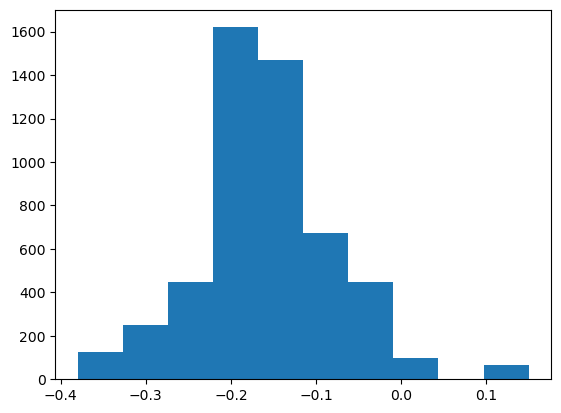

In [7]:
# See the distribution of metallicities of stars in the different clusters
plt.hist(clusters_stars_df['synth_MH']);

# Indexation dictionaries

In [8]:
z_elements = [11,12,13,14,20,21,22,23,24,25,26,27,28,29,30] # Future input of the atomic number of elements we want to use
z_to_idx = {z: i for i, z in enumerate(z_elements)}
idx_to_z = {value:key for (key,value) in z_to_idx.items()}

In [9]:
z_to_str = {
    1: 'Hydrogen',
    2: 'Helium',
    6: 'Carbon',
    7: 'Nitrogen', 
    8: 'Oxygen',
    9: 'Fluorine',
    10: 'Neon',
    11: 'Sodium',
    12: 'Magnesium',
    13: 'Aluminum',
    14: 'Silicon',   
    15: 'Phosphorus',   
    16: 'Sulphur',
    17: 'Chlorine',
    18: 'Argon',
    19: 'Potassium',
    20: 'Calcium',
    21: 'Scandium', 
    22: 'Titanium',
    23: 'Vanadium',
    24: 'Chromium',
    25: 'Manganese',
    26: 'Iron',
    27: 'Cobalt',
    28: 'Nickel',
    29: 'Copper',
    30: 'Zinc',
    39: 'Yttrium', # From here not available in Yields
    40: 'Zirconium',
    42: 'Molybdenum',
    56: 'Barium',
    58: 'Cerium',
    59: 'Praseodynium',
    60: 'Neodynium'}
str_to_z = {value:key for (key,value) in z_to_str.items()}

In [10]:
z_to_df = {
    11: 'Na 1',
    12: 'Mg 1',
    13: 'Al 1',
    14: 'Si 1',
    20: 'Ca 1',
    21: 'Sc 2', 
    22: 'Ti 2', # More reliable, same measurements (~11) 
    23: 'V 1',
    24: 'Cr 1',
    25: 'Mn 1',
    26: 'Fe 1', # Most measurements (90-100) vs Fe 2 (<10)
    27: 'Co 1',
    28: 'Ni 1',
    29: 'Cu 1',
    30: 'Zn 1',
    39: 'Y 2',
    40: 'Zr 1', # Dont know which one is more reliable, same measurementes (~1)
    42: 'Mo 1',
    56: 'Ba 2',
    58: 'Ce 2',
    59: 'Pr 2',
    60: 'Nd 2',
    }
df_to_z = {value:key for (key,value) in z_to_df.items()}

In [11]:
# To see if the mapping is correct
for j, z in enumerate(z_elements):
    print(j, z, z_to_str[z], z_to_df[z])

0 11 Sodium Na 1
1 12 Magnesium Mg 1
2 13 Aluminum Al 1
3 14 Silicon Si 1
4 20 Calcium Ca 1
5 21 Scandium Sc 2
6 22 Titanium Ti 2
7 23 Vanadium V 1
8 24 Chromium Cr 1
9 25 Manganese Mn 1
10 26 Iron Fe 1
11 27 Cobalt Co 1
12 28 Nickel Ni 1
13 29 Copper Cu 1
14 30 Zinc Zn 1


## Setting T and X

In [12]:
'''# Without element selection
clusters = np.array(cluster_df['cluster']) # Cluster names
K = len(clusters) # Number of clusters

# Setting T (and R, for later A_m)
T_m, T_sd = np.array(cluster_df['age']), np.array(cluster_df['err_age'])
cluster_R = np.array(cluster_df['Rgc']).reshape(-1,1) # Is Rgc the radius in pc? If not, where to find cluster radius

# We reorder the arrays based on cluster Age T_m from oldest to youngest
cluster_sort_idx = np.argsort(T_m)[::-1]
clusters = clusters[cluster_sort_idx]
T_m, T_sd = T_m[cluster_sort_idx], T_sd[cluster_sort_idx]

# Setting X
# Approach in case I want to keep all the elements and set as NaN for the stars with missing ones.
X = [] # List with matrices X[k] k=1,...,K of shape N_cluster_stars x N_elements
elements = np.unique(clusters_stars_df['element']) # All the available element abundances (in order)
element_idx = lambda element: np.where(elements == element)[0][0] # Mapping for element to idx in ordered array
for k, cluster in enumerate(clusters):
    cluster_mask = clusters_stars_df['cluster'] == cluster
    cluster_individual_stars = clusters_stars_df[cluster_mask]
    cluster_stars = np.unique(cluster_individual_stars['star'])
    star_elements = np.unique(cluster_individual_stars['element'])
    Xk = np.full((len(cluster_stars), len(elements)), np.nan) # Empty matrix
    for i, star in enumerate(cluster_stars):
        star_mask = cluster_individual_stars['star'] == star
        individual_star = cluster_individual_stars[star_mask]       
        elements_idx = list(individual_star['element'].apply(element_idx)) # Map the available elements to their respective ordered index
        Xk[i,elements_idx] = individual_star['synth_x_over_h'] # 'synth_x_over_h', 'synth_absolute_abund'
    X.append(Xk)''';

In [13]:
# With element selection
clusters = np.array(cluster_df['cluster']) # Cluster names
K = len(clusters) # Number of clusters

# Setting T (and R, for later A_m)
T_m, T_sd = np.array(cluster_df['age']), np.array(cluster_df['err_age'])
cluster_R = np.array(cluster_df['Rgc']).reshape(-1,1) # Is Rgc the radius in pc? If not, where to find cluster radius

# We reorder the arrays based on cluster Age T_m from oldest to youngest
cluster_sort_idx = np.argsort(T_m)[::-1]
clusters = clusters[cluster_sort_idx]
T_m, T_sd = T_m[cluster_sort_idx], T_sd[cluster_sort_idx]

# Setting X
X = [] # List with matrices X[k] k=1,...,K of shape N_cluster_stars x N_elements
for k, cluster in enumerate(clusters):
    cluster_mask = clusters_stars_df['cluster'] == cluster
    cluster_individual_stars = clusters_stars_df[cluster_mask]
    cluster_stars = np.unique(cluster_individual_stars['star'])
    star_elements = np.unique(cluster_individual_stars['element'])
    Xk = np.full((len(cluster_stars), len(z_elements)), np.nan) # Empty matrix
    for i, star in enumerate(cluster_stars):
        star_mask = cluster_individual_stars['star'] == star
        individual_star = cluster_individual_stars[star_mask]       
        for l, element in enumerate(individual_star['element']):
            try:
                j = z_to_idx[df_to_z[element]] # We recover the index j for the element in the df
                Xk[i,j] = np.array(individual_star['synth_absolute_abund'])[l] #'synth_x_over_h', 'synth_absolute_abund'
            except:
                continue
    X.append(Xk)

In [14]:
len(X)

47

In [15]:
# Add in case I want to exclude stars with missing values in any of the elements
# obs: by doing this I lose up to 3 clusters, since all of its stars have a missing element,
# and also I leave a cluster with 1 star
exclude_mask = np.ones(len(z_elements), dtype='bool')
exclude_idx = []
for k in range(K):
    exclude_idx_k = []
    for i in range(len(X[k])):
        idx_to_exclude = np.argwhere(np.isnan(X[k][i]))
        if len(idx_to_exclude) > 0:
            #print(k,i)
            exclude_idx_k.append(i)
        else:
            continue # To only have either empty lists or lists with the indexes to exclude
            #exclude_idx_k.append(None) # To see the clusters after the potential removal
    exclude_idx.append(exclude_idx_k)

X_ = []
exclude_cluster = []
cluster_mask = np.ones(len(clusters), dtype='bool')
for k, cluster in enumerate(clusters):
    if len(X[k]) > len(exclude_idx[k]): # If The stars I remove don't delete the whole cluster
        exclude_mask = np.ones(len(X[k]), dtype='bool')
        exclude_mask[exclude_idx[k]] = 0
        X[k] = X[k][exclude_mask,:]
        X_.append(X[k])
    else: # I lose all the stars in the cluster, I remove it.
        print('Removed cluster {}: {}'.format(k,cluster))
        exclude_cluster.append(k)

# Change arrays after removing the clusters
X = X_
cluster_mask[exclude_cluster] = 0
clusters = clusters[cluster_mask]
K = len(clusters)
T_m, T_sd = T_m[cluster_mask], T_sd[cluster_mask]
cluster_R = cluster_R[cluster_mask]

# In case I want to change dfs after removing clusters
#cluster_df = cluster_df[cluster_mask]
#clusters_stars_df = clusters_stars_df[[cluster in clusters for cluster in clusters_stars_df['cluster']]]

Removed cluster 22: UBC_44


In [16]:
len(X)

46

In [17]:
## Adding absolute H, He somehow
#for k, cluster in enumerate(clusters):
#    X[k] = np.hstack([0.019 * np.ones((len(X[k]),2)),X[k]])

TO ADD: 
- How to treat the missing H, He abundances?

In [18]:
'''
Add in case I want to exclude elements missing in at least one of the stars, for all the clusters
# obs: by doing this I lose 7 elements (on the original 47 clusters)
exclude_mask = np.ones(len(elements), dtype='bool')
exclude_idx = []
for k in range(K):
    for i in range(len(X[k])):
        idx_to_exclude = np.argwhere(np.isnan(X[k][i]))
        if len(idx_to_exclude) > 0:
            idx_to_exclude = idx_to_exclude[0][0]
            exclude_idx.append(idx_to_exclude)
exclude_idx = np.unique(exclude_idx)
exclude_mask[exclude_idx] = 0
for k in range(K):
    X[k] = X[k][:,exclude_mask]
''';

# CalY

In [19]:
# Initial Mass Function IMF
def chabrier_IMF(M,M_c=0.079,s=0.69,A_phi=0.842984,B_phi=0.235480):
    assert (M>=0.1) & (M<=120), 'Mass should be in range [0,1,120]'
    return A_phi * M**(-1) * np.exp(-(np.log(M)-np.log(M_c))**2/(2*s**2)) if M <= 1 else B_phi * M**(-2.3)

chabrier_IMG_vfunc = np.vectorize(chabrier_IMF) # Vectorized function to apply to arrays

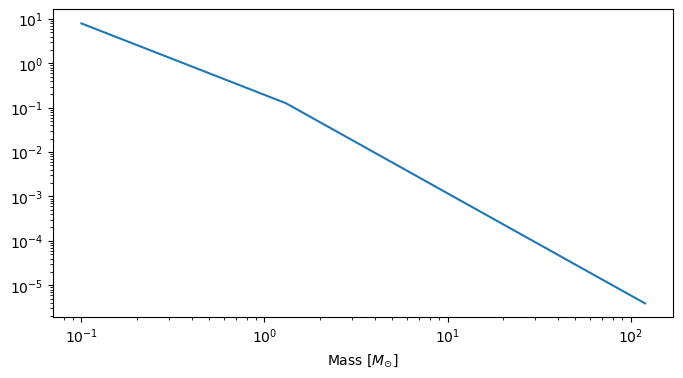

In [20]:
Ms = np.linspace(0.1,120,100)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4))
ax.plot(Ms,chabrier_IMG_vfunc(Ms))
ax.set_xlabel(r'Mass [$M_{\odot}$]')
#ax.set_ylabel(r'Mass fraction')
ax.set_xscale('log')
ax.set_yscale('log')

In [21]:
def PL_DTD(t,T,dt,a=0.15242, tmin=0.0035):
    #Already integrated expresion of the DTD between (T-t) and (T-t) + dt
    return a * (-1/0.12) * (((T-t)+dt)**(-0.12) - (T-t)**(-0.12)) if (T-t) >= tmin else 0

'''
def PL_DTD(tau,a=0.15242):
    return a / (tau)**1.12
''';

In [22]:
IMF_dict = {'chabrier': chabrier_IMF}
DTD_dict = {'power law': PL_DTD}

In [23]:
AGB_y_004 = pd.read_csv("/home/kwalsen/Documents/ERIS/networks/data/yields/AGB_004.csv") # Interpolated to include bin 6-7
AGB_y_02 = pd.read_csv("/home/kwalsen/Documents/ERIS/networks/data/yields/AGB_02.csv") # Interpolated to include bin 6-7
SNII_y_004 = pd.read_csv("/home/kwalsen/Documents/ERIS/networks/data/yields/SNII_004.csv")
SNII_y_02 = pd.read_csv("/home/kwalsen/Documents/ERIS/networks/data/yields/SNII_02.csv")
SNIa_y = pd.read_csv("/home/kwalsen/Documents/ERIS/networks/data/yields/SNIa.csv")
Yields_dict = {'AGB_004': AGB_y_004,
               'AGB_02': AGB_y_004,
               'SNII_004': SNII_y_004,
               'SNII_02': SNII_y_02,
               'SNIa': SNIa_y}

In [24]:
def calY(t,T,dt,G,Xk,
         A=0.028,
         IMF='chabrier', DTD='power law',
         IMF_dict = IMF_dict, DTD_dict = DTD_dict, Yields_dict = Yields_dict):
    '''
    dt:
    tmin: Minimum delay time tmin=35Myr=0.0035Gyr
    Xk of shape I x J
    
    Returns:
    
    Y_m: Median of normal distribution
    Y_sd: Standard deviation of normal distribution
    
    '''
    
    I, J = np.shape(Xk)
    
    # Masses
    AGB_m = np.array([0.85,0.918,0.992,1.071,1.154,1.239,1.315,1.407,1.499,1.583,1.667,1.75,1.832,1.85,1.9,2,2.2,2.5,3,3.5,4,4.5,5])
    SNII_m = np.array([6,7,9,12,15,20,30,40,60,100,120])
    m = np.hstack([AGB_m, SNII_m]) # Array of all mass bins (except SNIa)
    
    ## Treat the lifetimes here?
    LT = pd.read_csv("/home/kwalsen/Documents/ERIS/networks/data/yields/lifetime.csv") 
    a0, a1, a2 = np.polyfit(x=np.log10(np.tile(LT['mass'],6)),
                            y=np.log10(np.transpose(np.array(LT)[:,1:]).flatten()),
                            deg=2)[::-1]
    fit = lambda x: a0 + a1*x + a2 * x**2
    AGB_t = fit(np.log10(AGB_m))
    SNII_t = fit(np.log10(SNII_m))
    
    # Number of stars per mass bin
    p_m = np.array([integrate.quad(func=IMF_dict[IMF], a=m[i], b=m[i+1])[0] for i in range(len(m)-1)]) # Cumulative of IMF for the mass bin m
    
    # We drop the last value since in the counts we sum over all the bin, indexing with the lower bound
    m = m[:-1]
    SNII_t = SNII_t[:-1] # Since we drop m=120
    
    # Counts per mass bin in cluster of gas mass G
    n_m = G*(p_m/m) # Expected total number of stars of mass bin m
    #n_m = norm.rvs(loc=G*(p/m[:-1]), scale=G*(p/m[:-1])) # May contain negative values since the high scale
    
    # Define A' for w_m
    P316 = np.sum(p_m[np.where((m>3)*(m<16))]) # Sum of pdf in-between bins (relies on grid m), != 0.0385 (Yates et Al. 2013) 
    A_prime = A*P316 # A' 
    
    AGB_n_m = n_m[(m>=0.85)*(m<=5)]#.reshape(-1,1)
    SNIa_n_m = np.array([A_prime*np.sum(n_m[(m>=0.85)*(m<8)])])
    SNII_n_m = np.hstack([(1-A)*n_m[(m>=6)&(m<16)],n_m[(m>=16)]])#.reshape(-1,1)
    
    # Define w_m for Y_m
    def w_m(t,T,dt,Xki):
        '''
        I want it to return a matrix of shape [len(m),J] where J is the number of species sampled for stars in cluster k  
        Input:
        t,T,tau,
        Xki=X[k][i] matrix of star i's abundances in cluster k,
        n_m = dict of star counts for each mass bin m of different yield processes
        
        '''
        J = len(Xki)
        
        # Yields
        SNIa_y = Yields_dict['SNIa']
        if np.sum(Xki[2:])/np.sum(Xki) < 0.02: # Assuming the first two elements are H,He (NOT YET DONE!)
            AGB_y = Yields_dict['AGB_004'][:-1] # Since we drop m=6 in this case
            SNII_y = Yields_dict['SNII_004'][:-1] # Since we drop m=120 in this case
        else:
            AGB_y = Yields_dict['AGB_02'][:-1] # Since we drop m=6 in this case
            SNII_y = Yields_dict['SNII_02'][:-1] # Since we drop m=120 in this case
        
        # Arrays with yields for J species
        AGB_w = np.zeros((len(AGB_y),J))
        SNIa_w = np.zeros(J)
        SNII_w = np.zeros((len(SNII_y),J))
        for j, z in enumerate(z_elements): # For each species, j -> element need a mapping maybe
            element = z_to_str[z] # Convert the element z to the column in the Yields
            if element in AGB_y.columns:
                AGB_w[:,j] = ((Xki[j] * AGB_y['total_ejected'] + AGB_y[element]) * ((AGB_t >= ((T-t) - dt)) * (AGB_t < ((T-t) + dt)))) # 0.85 < m <= 7 
            if element in SNIa_y.columns:
                SNIa_w[j] = (Xki[j] * SNIa_y['Total_metal'] + SNIa_y[element]) * DTD_dict[DTD](t,T,dt) # 0.85 < m <= 8
                #SNIa_w[j] = (Xki[j] * SNIa_y['Total_metal'] + SNIa_y[element]) * integrate.quad(DTD_dict[DTD], a=(T-t), b=(T-t) + dt)[0] # 0.85 < m <= 8
            if element in SNII_y.columns:
                SNII_w[:,j] = (Xki[j] * SNII_y['total_ejected'] + SNII_y[element]) * ((SNII_t >= ((T-t) - dt)) * (SNII_t < ((T-t) + dt))) # 7 < m <= 16; m>16
        
        Wm = {'AGB': AGB_w, 'SNIa': SNIa_w, 'SNII': SNII_w}
            
        return Wm
    
    # Define omega_m for Y_sd
    def omega_m(Wm,n_m):
        '''
        Returns
        
        (JxJ) matrix
        '''
        '''
        J = len(Wm)
        out = np.zeros((J,J)) # for each mass I have a matrix of JxJ to then sum over all m matrices        
        for j1 in range(J):
            out[j1,j1] = Wm[j1]**2
            for j2 in range(j1+1,J):
                out[j1,j2] = Wm[j1]**2 + Wm[j2]**2
        
        # To reflect the upper diagonal values to lower diagonal
        out = out + np.transpose(out) - np.diag(np.diag(out)) # To reflect the upper diagonal values to lower diagonal
        '''
        out = np.dot(np.dot(np.transpose(Wm), np.diag(n_m)), Wm)
        
        return out
    
    Y_m = np.zeros(J) # Mean of total mass yields
    Y_sd = np.zeros((J,J)) # Standard deviation of total mass yields
    for i in range(I): # Each star in cluster k
        Xki = Xk[i] # Vector with species abundances of star i
        # Get the yields based in the abundances of star i
        Wm = w_m(t,T,dt,Xki) 
        AGB_w = Wm['AGB']
        SNIa_w = Wm['SNIa']
        SNII_w = Wm['SNII']
        
        Y_m += np.sum(AGB_n_m.reshape(-1,1) * AGB_w, axis=0) + SNIa_n_m * SNIa_w + np.sum(SNII_n_m.reshape(-1,1) * SNII_w, axis=0)
        Y_sd = omega_m(AGB_w, AGB_n_m) + omega_m(SNIa_w.reshape(1,-1), SNIa_n_m) + omega_m(SNII_w, SNII_n_m)
        
        #Y_sd += SNIa_n_m *omega_m(SNIa_w)    
        #for m in range(len(AGB_w)):
        #    Y_sd += AGB_n_m[m] * omega_m(AGB_w[m])
        #for m in range(len(SNII_w)):
        #    Y_sd += SNII_n_m[m] * omega_m(SNII_w[m])     
                
    Y_m = Y_m / I 
    Y_sd = Y_sd / I**2

    return Y_m, Y_sd

## Setting prior for T, G, A

- Decide wether set the priors as functions or arrays

In [25]:
# If priors are set as functions (Improve if finally needed)
def Pr_T(loc, scale, size, **kwargs):
    return norm.rvs(loc, scale, size, **kwargs)

def Pr_G(s,loc,scale):
    return lognorm(s=s,loc=loc,scale=scale)

def Pr_A(loc,scale,size,**kwargs):
    return expon.rvs(loc,scale,size,**kwargs)

print('Pr_T')
print(Pr_T(loc=T_m, scale=T_sd,size=K))

print('Pr_G')
G_m, G_sd = 1e5, 1e5 # Don't know the actual values yet
s = 1 # Shape parameter for distribution, don't know actual useful value for this yet
N = 10 # Bins of equal probability, don't know if is K or a value sufficiently high
G_bins = randint.rvs(low=1, high=N+1, loc=0, size=K)
print(G_bins)
print(Pr_G(s,G_m,G_sd).ppf(q=(G_bins-0.5)/N))

print('Pr_A')
A_m = distance_matrix(cluster_R, cluster_R, p=1)
A_m = np.where(A_m!=0, 1/A_m,0) # Find a better way to compute it and avoid warning
print(A_m)
print(Pr_A(loc=0,scale=A_m, size=(K,K)))    

Pr_T
[7.92241877 7.21640815 4.18020886 3.01982711 3.13607488 2.88630179
 2.91351569 2.35114018 2.27250235 2.0149401  1.89018427 1.73300597
 1.58479867 1.53434785 1.54244789 1.45326203 1.35391167 1.31145163
 1.20356341 1.11372928 1.0984355  0.99131111 1.01400475 0.60714056
 0.76801462 0.92062079 0.77309875 0.71835197 0.58710229 0.70110609
 0.67229918 0.74942542 0.58836148 0.65526023 0.47810334 0.53322628
 0.43967419 0.4826263  0.64632102 0.40971126 0.55411633 0.52390205
 0.40914734 0.26801693 0.17488576 0.20004185]
Pr_G
[9 2 6 7 9 2 6 5 3 8 3 3 3 1 9 8 3 9 5 7 5 6 1 1 6 3 1 7 5 8 8 5 4 8 8 3 3
 3 5 6 9 6 7 3 9 6]
[381914.42726747 135471.75679133 213389.81050953 247008.53589351
 381914.42726747 135471.75679133 213389.81050953 188191.3458984
 150941.62838633 296303.10841583 150941.62838633 150941.62838633
 150941.62838633 119304.08166987 381914.42726747 296303.10841583
 150941.62838633 381914.42726747 188191.3458984  247008.53589351
 188191.3458984  213389.81050953 119304.08166987 119304.

/tmp/ipykernel_18709/4076733945.py:24: RuntimeWarning: divide by zero encountered in divide
  A_m = np.where(A_m!=0, 1/A_m,0) # Find a better way to compute it and avoid warning


In [26]:
# If priors are set as arrays
print('Pr_T')
Pr_T = norm.rvs(loc=T_m, scale=T_sd, size=K)
print(Pr_T)

print('Pr_G')
G_m, G_sd = 1e5, 1e5 # Don't know the actual values yet, set it to get a range of values of order 1e5
s = 1 # Shape parameter for distribution, don't know actual useful value for this yet
N = 10 # Bins of equal probability, don't know if N=K or a value sufficiently high
G_bins = randint.rvs(low=1, high=N+1, loc=0, size=K)
Pr_G = lognorm.ppf(q=(G_bins-0.5)/N, s=s, loc=G_m, scale=G_sd)
print(G_bins)
print(Pr_G)

print('Pr_A')
A_m = distance_matrix(cluster_R, cluster_R, p=1)
A_m = np.where(A_m!=0, 1/A_m,0) # Find a better way to compute it and avoid warning
print(A_m)
Pr_A = expon.rvs(loc=0, scale=A_m, size=(K,K))
print(Pr_A)

Pr_T
[8.17137786 7.14667169 4.21977113 3.1472236  2.99158641 2.7075048
 2.79418647 2.33777582 2.33470071 2.0583397  1.92539756 1.7741929
 1.62946931 1.51912024 1.48524405 1.43529463 1.40445916 1.30583029
 1.18280678 1.11879601 1.11954895 0.9955211  0.81108114 0.61704503
 0.95669805 0.6706158  0.65719689 0.78572024 0.73026    0.77631025
 0.74575509 0.58575415 0.68684708 0.66110836 0.55570739 0.48836062
 0.470805   0.4832568  0.45577517 0.52644356 0.41315818 0.36538867
 0.38401863 0.24055909 0.26239665 0.19918054]
Pr_G
[ 1 10  1  3  7  3  9  1  7  7  2 10 10  9  7  1 10  8  1 10  7  7  7 10
  7  8  3  7  1  7  1  2  2  4  8  4 10  8  8  1  7  7  5  8 10  6]
[119304.08166987 618025.1602233  119304.08166987 150941.62838633
 247008.53589351 150941.62838633 381914.42726747 119304.08166987
 247008.53589351 247008.53589351 135471.75679133 618025.1602233
 618025.1602233  381914.42726747 247008.53589351 119304.08166987
 618025.1602233  296303.10841583 119304.08166987 618025.1602233
 247008.53589

/tmp/ipykernel_18709/183947318.py:17: RuntimeWarning: divide by zero encountered in divide
  A_m = np.where(A_m!=0, 1/A_m,0) # Find a better way to compute it and avoid warning


## Initialization

In [27]:
'''# If the priors were set as functions
T = T_m # Pr_T(loc=T_m, scale=T_sd,size=K)

G_m, G_sd = 0, 1 # Don't know the actual values yet
s = 1 # Shape parameter for distribution, don't know actual useful value for this yet
N = K # Bins of equal probability, don't know if is K or a value sufficiently high
G_bins = randint.rvs(low=1, high=N+1, loc=0, size=K)
G = Pr_G(s,G_m,G_sd).ppf(q=(G_bins-0.5)/N)

# TO ADD: Initialization for A''';

In [28]:
# If the priors were set as arrays
T = T_m # Pr_T, get erros since sampling here changes the order in ages, should rearange after setting prior?
G = Pr_G

dt = 2 # Which value of dt is reasonable? also for G_m, G_sd for G
J = np.shape(X[0])[1] # Number of species

# Get Y_m
Y_m = np.zeros((K,K,J)) # I use only half of the arrays, should optimize space if necessary
Y_sd = np.zeros((K,K,J,J))
for l in np.arange(len(X)):
    for k in range(l+1,len(X)):
        Y_m[l,k,:], Y_sd[l,k,:,:] = calY(T[k], T[l], dt, G[k], X[k])
print(Y_m.shape)
print(Y_sd.shape)

# Initialization of A
A = np.zeros((K,K)) # Doesn't include pristine gas nor has H,He involved
for k in range(1,len(X)): # A[0,0] = 0
    A[:k,k] = np.linalg.pinv(np.dot(Y_m[:k,k],np.mean(X[k], axis=0)).reshape(-1,1))
A = A - A*(A<0) # We subtract the negative values out of A
print(A.shape)
print(A[:4,:4])

(46, 46, 15)
(46, 46, 15, 15)
(46, 46)
[[0.00000000e+00 1.48350316e-04 9.31540281e-04 1.93073394e-05]
 [0.00000000e+00 0.00000000e+00 1.19149406e-03 1.93539839e-07]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 5.62688742e-07]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]]


For the initialization of A:

- How to set Y[0] and A[0,:] with the species abundance in pristine gas (75% H, 25% He)

In [29]:
# logLik and logPr
def logLikelihood(T,G,X,Y_m,Y_sd,A):
    '''
    Note: NEED POSITIVE SEMIDEFINITE COV MATRIX FOR logLik
    '''
    out = 0
    for k in range(1,len(X)): # For each cluster k (excluding the first one: to be pristine gas)
        mean = np.sum(A[:k,k].reshape(-1,1) / G[k] * Y_m[:k,k], axis=0) 
        cov = np.sum((A[:k,k] / G[k])**2 * np.transpose(Y_sd[:k,k], axes=[1,2,0]), axis=2) # each term shape (J,J,{Tl>Tk})
        print('Cluster {} with {} stars'.format(k, len(X[k])))
        for i in range(len(X[k])): # For each star i in cluster k
            try:
                out += multivariate_normal.logpdf(X[k][i], mean=mean, cov=cov)
            except:
                print('Failed for (k,i)=({},{})'.format(k,i))
                print(np.linalg.eigvals(cov))
                #print(cov)
    return out

def logPrior(T,T_m,T_sd,A,A_m):
    '''
    '''
    out = 0
    for l in range(len(T)): # For each cluster
        out += norm.logpdf(T[l], loc=T_m[l], scale=T_sd[l])
        for k in range(l+1,len(T)):
            out += expon.logpdf(A[l,k], scale=1/A_m[l,k]) # Parametrization: scale = 1/lambda
            
    return out

In [30]:
# logLik fails for all pairs of clusters, all stars
# The problem might be in Y_sd or A
logLikelihood(T,G,X,Y_m,Y_sd,A)

Cluster 1 with 4 stars
Failed for (k,i)=(1,0)
[ 0.00000000e+00+0.00000000e+00j  5.60478546e-18+0.00000000e+00j
 -3.17733103e-34+0.00000000e+00j -1.98766119e-34+0.00000000e+00j
  4.05307434e-35+4.33124701e-35j  4.05307434e-35-4.33124701e-35j
 -7.23215174e-35+0.00000000e+00j  3.64871834e-35+0.00000000e+00j
  2.60111065e-35+0.00000000e+00j -1.51734810e-35+3.45709831e-35j
 -1.51734810e-35-3.45709831e-35j -1.78472454e-36+0.00000000e+00j
 -3.48177164e-35+1.24142616e-35j -3.48177164e-35-1.24142616e-35j
 -1.69557510e-35+0.00000000e+00j]
Failed for (k,i)=(1,1)
[ 0.00000000e+00+0.00000000e+00j  5.60478546e-18+0.00000000e+00j
 -3.17733103e-34+0.00000000e+00j -1.98766119e-34+0.00000000e+00j
  4.05307434e-35+4.33124701e-35j  4.05307434e-35-4.33124701e-35j
 -7.23215174e-35+0.00000000e+00j  3.64871834e-35+0.00000000e+00j
  2.60111065e-35+0.00000000e+00j -1.51734810e-35+3.45709831e-35j
 -1.51734810e-35-3.45709831e-35j -1.78472454e-36+0.00000000e+00j
 -3.48177164e-35+1.24142616e-35j -3.48177164e-35-1.2

0

In [31]:
for l in range(1,len(X)):
    for k in range(l+1,len(X)):
        print(np.linalg.eigvals(Y_sd[l,k]))

[ 0.00000000e+00+0.00000000e+00j  1.35859829e+00+0.00000000e+00j
 -4.35303869e-17+0.00000000e+00j  1.72109577e-17+2.34412225e-17j
  1.72109577e-17-2.34412225e-17j -2.51990491e-17+0.00000000e+00j
  1.54577651e-17+8.33626248e-18j  1.54577651e-17-8.33626248e-18j
  1.42248611e-17+0.00000000e+00j -1.62685257e-17+0.00000000e+00j
 -1.15737236e-17+0.00000000e+00j -6.24175365e-18+0.00000000e+00j
 -3.07213334e-18+0.00000000e+00j  2.46410081e-18+2.68439935e-18j
  2.46410081e-18-2.68439935e-18j]
[ 0.00000000e+00+0.00000000e+00j  4.13061769e+00+0.00000000e+00j
 -9.15353308e-17+0.00000000e+00j  1.89332910e-16+0.00000000e+00j
  5.44334863e-17+0.00000000e+00j -5.26270951e-17+8.70189692e-18j
 -5.26270951e-17-8.70189692e-18j  3.09659262e-17+2.94001268e-17j
  3.09659262e-17-2.94001268e-17j -1.84894623e-17+1.83193482e-17j
 -1.84894623e-17-1.83193482e-17j  6.82057899e-18+7.25562064e-18j
  6.82057899e-18-7.25562064e-18j  8.00020791e-18+0.00000000e+00j
 -1.02313471e-17+0.00000000e+00j]
[ 4.44089210e-16+0.000

[ 0.00000000e+00+0.00000000e+00j  2.48653862e+01+0.00000000e+00j
 -1.75178912e-15+0.00000000e+00j  5.33542715e-16+0.00000000e+00j
  2.17995348e-16+2.20269423e-16j  2.17995348e-16-2.20269423e-16j
 -2.97357452e-16+3.54626275e-17j -2.97357452e-16-3.54626275e-17j
  2.20749107e-16+0.00000000e+00j -1.75186541e-16+1.17686631e-16j
 -1.75186541e-16-1.17686631e-16j -5.83189048e-17+1.59907596e-16j
 -5.83189048e-17-1.59907596e-16j  6.90057547e-17+0.00000000e+00j
  3.45399709e-18+0.00000000e+00j]
[ 0.00000000e+00+0.00000000e+00j  1.28200186e+02+0.00000000e+00j
  4.26435670e-15+2.33068078e-15j  4.26435670e-15-2.33068078e-15j
  2.09137443e-15+0.00000000e+00j -1.93339139e-15+0.00000000e+00j
 -1.40215438e-15+6.49806414e-16j -1.40215438e-15-6.49806414e-16j
 -1.20830814e-15+0.00000000e+00j  5.75807346e-16+3.82344685e-16j
  5.75807346e-16-3.82344685e-16j -2.96336064e-16+7.76422500e-16j
 -2.96336064e-16-7.76422500e-16j -4.79363805e-16+0.00000000e+00j
  1.09038270e-16+0.00000000e+00j]
[-2.84217094e-14+0.000

[ 2.84217094e-14+0.00000000e+00j  1.63422399e+02+0.00000000e+00j
  4.85563173e-15+0.00000000e+00j -2.55371844e-15+2.05643198e-15j
 -2.55371844e-15-2.05643198e-15j -2.41815609e-15+0.00000000e+00j
 -1.81439282e-15+0.00000000e+00j  2.18520571e-15+0.00000000e+00j
  8.21265292e-16+1.34947543e-15j  8.21265292e-16-1.34947543e-15j
  1.48938296e-15+0.00000000e+00j  4.88637198e-16+3.91967306e-16j
  4.88637198e-16-3.91967306e-16j  7.39336622e-17+3.33947424e-16j
  7.39336622e-17-3.33947424e-16j]
[-1.77635684e-15+0.00000000e+00j  1.63109422e+01+0.00000000e+00j
 -4.42973106e-16+0.00000000e+00j  4.54399145e-16+7.96167379e-17j
  4.54399145e-16-7.96167379e-17j -2.43777850e-16+8.70801328e-17j
 -2.43777850e-16-8.70801328e-17j  1.36614733e-16+1.44437987e-16j
  1.36614733e-16-1.44437987e-16j -5.54321424e-17+6.55866344e-17j
 -5.54321424e-17-6.55866344e-17j  4.35617959e-17+9.64399732e-17j
  4.35617959e-17-9.64399732e-17j  8.19858197e-17+0.00000000e+00j
  6.42289310e-17+0.00000000e+00j]
[ 0.00000000e+00+0.000

[ 0.00000000e+00+0.00000000e+00j  9.53431079e+02+0.00000000e+00j
  1.06107821e-14+1.42937718e-14j  1.06107821e-14-1.42937718e-14j
  1.93901211e-14+0.00000000e+00j  1.54439728e-14+1.02236891e-14j
  1.54439728e-14-1.02236891e-14j -1.24090095e-14+2.75286586e-15j
 -1.24090095e-14-2.75286586e-15j -5.71132296e-15+0.00000000e+00j
 -4.02622273e-15+0.00000000e+00j -2.33219627e-15+0.00000000e+00j
  8.18360742e-15+0.00000000e+00j  4.58200482e-15+4.24433278e-16j
  4.58200482e-15-4.24433278e-16j]
[ 0.00000000e+00+0.00000000e+00j  2.10558850e+03+0.00000000e+00j
  6.43449788e-14+0.00000000e+00j -4.84125949e-14+0.00000000e+00j
 -1.83215753e-14+6.90489652e-15j -1.83215753e-14-6.90489652e-15j
 -5.58503561e-15+1.68078998e-14j -5.58503561e-15-1.68078998e-14j
  8.97711341e-15+6.83503532e-15j  8.97711341e-15-6.83503532e-15j
  2.35455591e-15+1.02166305e-14j  2.35455591e-15-1.02166305e-14j
  2.10901742e-15+0.00000000e+00j  2.09892810e-15+3.88116116e-15j
  2.09892810e-15-3.88116116e-15j]
[ 0.00000000e+00+0.000

[ 0.00000000e+00+0.00000000e+00j  3.15974821e+02+0.00000000e+00j
  1.29649416e-14+0.00000000e+00j -7.70448784e-15+0.00000000e+00j
  4.50392811e-15+8.55932139e-16j  4.50392811e-15-8.55932139e-16j
  2.31366586e-15+1.20845784e-15j  2.31366586e-15-1.20845784e-15j
 -6.95512596e-16+3.00516104e-15j -6.95512596e-16-3.00516104e-15j
 -4.43632177e-15+0.00000000e+00j -2.85647660e-15+6.28898054e-16j
 -2.85647660e-15-6.28898054e-16j  3.61495964e-16+0.00000000e+00j
 -5.07283619e-16+0.00000000e+00j]
[ 0.00000000e+00+0.00000000e+00j  7.48286131e+03+0.00000000e+00j
 -1.51565780e-13+1.65978310e-14j -1.51565780e-13-1.65978310e-14j
  8.11363642e-14+0.00000000e+00j  6.34007372e-14+4.93789577e-14j
  6.34007372e-14-4.93789577e-14j -4.47256691e-14+5.98136520e-14j
 -4.47256691e-14-5.98136520e-14j  1.14331142e-14+4.67753481e-14j
  1.14331142e-14-4.67753481e-14j  2.20315736e-14+4.82325876e-15j
  2.20315736e-14-4.82325876e-15j -1.56350969e-14+0.00000000e+00j
 -2.60482047e-15+0.00000000e+00j]
[ 0.00000000e+00+0.000

In [32]:
# logPr seems to work fine
logPrior(T,T_m,T_sd,A,A_m)

-6870.082059014607

# MCMC

In [33]:
def MH(T, T_m, T_sd, G, X, Y_m, Y_sd, A, A_m, T_delta=5e-1, A_delta=5e-2):
    
    # Update each cluster age in T
    for k in range(len(X)):
        # We compute the current logLik and logPr
        logLik = logLikelihood(T,G,X,Y_m,Y_sd,A) 
        logPr = logPrior(T,T_m,T_sd,A,A_m)
        
        # All the arrays related to cluster order by age
        T_ = copy.deepcopy(T)
        T_m_ = copy.deepcopy(T_m)
        T_sd_ = copy.deepcopy(T_sd)
        G_ = copy.deepcopy(G)
        X_ = copy.deepcopy(X)
        Y_m_ = copy.deepcopy(Y_m)
        Y_sd_ = copy.deepcopy(Y_sd)
        A_ = copy.deepcopy(A)
        A_m_ = copy.deepcopy(A_m)
        
        # We change the age in cluster k
        T_[k] = np.abs(T_[k] + (uniform.rvs() - 0.5) * T_delta) # Consider the reflection if value is negative
    
        cluster_sort_idx = np.argsort(T_)[::-1] # Ages descending
        #if len(np.where(np.arange(len(T_)) != cluster_sort_idx)[0]) > 0: # If the order in ages change
        if np.all(cluster_sort_idx == np.arange(len(T_))): # If the order in ages change
            ## We reorder all the arrays based on new ages
            #
            T_ = T_[cluster_sort_idx]
            T_m_ = T_m_[cluster_sort_idx]
            T_sd_ = T_sd_[cluster_sort_idx]
            G_ = G_[cluster_sort_idx]
            
            #
            X_ = [X_[l] for l in cluster_sort_idx]
            
            #
            Y_m_ = Y_m_[cluster_sort_idx,:,:][:,cluster_sort_idx,:]
            for j in range(np.shape(Y_m_)[2]): # To move lower diagonal elements to upper diagonal
                Y_m_[:,:,j] = np.triu(Y_m_[:,:,j]) + np.transpose(np.tril(Y_m_[:,:,j]))
            
            #
            Y_sd_ = Y_sd_[cluster_sort_idx,:,:,:][:,cluster_sort_idx,:,:]
            for j1 in range(np.shape(Y_sd_)[2]): # To move lower diagonal elements to upper diagonal
                for j2 in range(np.shape(Y_sd_)[3]):
                    Y_sd_[:,:,j1,j2] = np.triu(Y_sd_[:,:,j1,j2]) + np.transpose(np.tril(Y_sd_[:,:,j1,j2]))
            
            A_ = A_[cluster_sort_idx,:][:,cluster_sort_idx]
            A_ = np.triu(A_) + np.transpose(np.tril(A_)) # To move lower diagonal elements to upper diagonal
            
            #
            A_m_ = A_m_[cluster_sort_idx,:][:,cluster_sort_idx] # Here we just have to reorder rows and columns
            
            # We compute the new logLik and logPr
            logLik_ = logLikelihood(T_,G_,X_,Y_m_,Y_sd_,A_) 
            logPr_ = logPrior(T_,T_m_,T_sd_,A_,A_m_)
            
            # We compute the acceptance probability
            a = np.min(1, np.exp((logPr_ - logPr) + (logLik_ - logLik)))
            v = uniform.rvs()
            if v <= a:
                T = T_
                T_m = T_m_
                T_sd = T_sd_
                G = G_
                X = X_
                Y_m = Y_m_
                Y_sd = Y_sd_
                A = A_
                A_m = A_m_
                
    # Update each element in the upper diagonal of A
    for l in range(len(X)):
        for k in range(l+1,len(X)):
            # We compute the current logLik and logPr
            logLik = logLik(T,G,X,Y_m,Y_sd,A) 
            logPr = logPr(T,T_m,T_sd,A,A_m)
            
            # We change A
            A_ = copy.deepcopy(A)
            A_[l,k] = np.abs(A[l,k] + (uniform.rvs() - 0.5) * A_delta)
            
            # We compute the new logLik and logPr
            logLik_ = logLikelihood(T,G,X,Y_m,Y_sd,A_) 
            logPr_ = logPrior(T,T_m,T_sd,A_,A_m)
            
            # We compute the acceptance probability
            a = np.min(1, np.exp((logPr_ - logPr) + (logLik_ - logLik)))
            v = uniform.rvs()
            if v <= a:
                A = A_
                
    # Update bin index of gas mass of each cluster in G
    for l in range(len(X)):
        # We compute the current logLik
        logLik = logLikelihood(T,G,X,Y_m,Y_sd,A)
        
        # We change G
        G_ = copy.deepcopy(G)
        #k = randint.rvs(low=l+1, high=len(X)) #
        k = np.random.choice(np.arange(len(X))[np.arange(len(X))!=l]) # Sample a random index except the current
        G_[l], G_[k] = G_[k], G_[l] # swap bin index is the same as swapping the values of G between the clusters
        
        # We compute the new logLik
        logLik_ = logLikelihood(T,G_,X,Y_m,Y_sd,A) 
        
        # We compute the acceptance probability
        a = np.min(1, np.exp(logLik_ - logLik))
        v = uniform.rvs()
        if v <= a:
            G = G_
             
    return T, T_m, T_sd, G, X, Y_m, Y_sd, A, A_m